In [1]:
import pandas as pd
import numpy as np
import xarray as xr
from pathlib import Path
import cartopy.crs as ccrs
import geopandas as gpd
from scipy.stats import rankdata
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from src.mplstyle import set as set_mplstyle
set_mplstyle("Fira Sans")

GHCND_PATH = Path("/mnt/d/climate_data/ghcnd/data/")
DATA_DOC_PATH = Path("./data/dataset_docs/")
OE_PATH = Path("/mnt/d/climate_data/HPD_CONUS_OEVENTS/")
ERA5_PATH = Path("/mnt/d/climate_data/ERA5_CONUS_STATIONS/")

OUTPUT_PATH = Path("./output/")
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

MERGED_OE_PATH = Path("./data/OE_tmean_era5/")
MERGED_OE_PATH.mkdir(parents=True, exist_ok=True)

In [2]:
def load_stn_tmean(stn_id):
    """
    Load GHCN-d TMEAN data that passed QC into a dataframe with datetime index
    """
    # Load and reindex data
    df = pd.read_csv(
        GHCND_PATH / f"{stn_id}.csv",
        low_memory=False,
        usecols=["DATE", "TMAX", "TMIN", "TMAX_ATTRIBUTES", "TMIN_ATTRIBUTES"],
        index_col="DATE",
        parse_dates=True,
        na_values=[9999, -9999],
    ).asfreq("D")

    # Remove flagged data
    tmax_split = df["TMAX_ATTRIBUTES"].str.split(",", expand=True)
    tmin_split = df["TMIN_ATTRIBUTES"].str.split(",", expand=True)

    ## Set to NaN if flag1 or flag2 is not empty
    df.loc[(tmax_split[0] != "") | (tmax_split[1] != ""), "TMAX"] = np.nan
    df.loc[(tmin_split[0] != "") | (tmin_split[1] != ""), "TMIN"] = np.nan

    df["TMEAN"] = (df["TMAX"] + df["TMIN"]) / 20  # TEMP data stored as tenth of Celsius

    return df.drop(columns=["TMAX", "TMIN", "TMAX_ATTRIBUTES", "TMIN_ATTRIBUTES"])


def merge_hpd_events_with_exg(prcp_df, tmean_df, era5_df):
    """
    Load ordinary events data of a given duration and merge it with an exogenous variable dataframe
    """
    prcp_df["DATE"] = (
        prcp_df.index.normalize()
    )  # Match with the daily value of the exogenous variable on the day of the precipitation event
    merged = (
        prcp_df.merge(tmean_df, how="left", on="DATE")
        .merge(era5_df, how="left", left_on="DATE", right_index=True)
        .drop(columns=["DATE"])
    )

    merged.index = prcp_df.index
    return merged

In [3]:
potential_stations = pd.read_csv(DATA_DOC_PATH / "potential_pt_stations.csv")
durations = ["1h", "24h"]

merged_dirs = {d: (MERGED_OE_PATH / d) for d in durations}
for path in merged_dirs.values():
    path.mkdir(parents=True, exist_ok=True)


final_stations = potential_stations.copy()
for idx, row in final_stations.iterrows():
    stn_id = row["StnID"]
    tmean_df = load_stn_tmean(stn_id)
    era5_df = pd.read_csv(ERA5_PATH / (stn_id + ".csv"), index_col=0, parse_dates=True)

    for d in durations:
        prcp_df = pd.read_csv(OE_PATH/d/(stn_id + ".csv"), index_col="datetime", parse_dates=True)
        merged = merge_hpd_events_with_exg(prcp_df, tmean_df, era5_df)
        merged.to_csv(merged_dirs[d] / (stn_id + ".csv"))
        # station info
        prev_size = len(merged)
        intersec_size = len(merged.dropna()) 
        pct_good = (intersec_size / prev_size) * 100
        final_stations.loc[final_stations["StnID"] == stn_id, "PCT_Good_Overlap_" + d] = round(pct_good, 1) 

# Create Definite Station List

In [4]:
clim_reg = pd.read_csv("./data/climate_region_conus.csv")
final_stations = final_stations.query("PCT_Good_Overlap_1h >= 80 and PCT_Good_Overlap_1h >= 80").copy()
final_stations["Clim_Reg"] = final_stations["State/Province"].map(clim_reg.set_index("STATE")["REGION"])
final_stations

,StnID,Lat,Lon,Elev,State/Province,Name,UTC_Offset,POR_Date_Range_P,PCT_POR_Good_P,Num_Years_P,POR_Date_Range_T,Num_Years_T,PCT_POR_Good_T,overlap_years,PCT_Good_Overlap_1h,PCT_Good_Overlap_24h,Clim_Reg
0,USC00410569,28.9798,-95.9749,15.8,TX,BAY CITY WATERWORKS,-6,19400601-20240417,57.1,84,19091001-20240331,116.0,70.2,85,86.8,89.3,S
1,USC00241737,47.8205,-112.1921,1172.0,MT,CHOTEAU,-7,19400101-20240401,93.8,84,18930101-20240504,132.0,83.6,85,96.1,98.0,NRP
2,USW00093914,31.7831,-95.6039,141.7,TX,PALESTINE 2 NE,-6,19400201-20240213,86.7,84,19300101-20240324,95.0,92.2,85,91.5,88.9,S
3,USC00414670,30.4452,-99.8044,532.5,TX,JUNCTION 4SSW,-6,19400301-20240401,90.4,84,18970127-20240503,128.0,75.0,85,84.2,88.4,S
5,USC00319476,35.6939,-77.9461,33.5,NC,WILSON 3 SW,-5,19400801-20240415,82.6,84,19161001-20240502,109.0,81.6,85,97.4,98.6,SE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,USC00170100,44.3738,-68.2591,143.3,ME,ACADIA NATIONAL PARK,-5,19820907-20120704,86.8,30,19820901-20140531,33.0,94.8,31,94.5,94.1,NE
1043,USC00478316,42.9676,-88.5495,283.2,WI,SULLIVAN 3 SE - WFO MKX,-6,19940901-20240402,85.6,30,19950101-20240504,30.0,96.8,30,98.2,97.2,UM
1044,USC00084095,25.5011,-80.5500,2.7,FL,HOMESTEAD GEN AVIATION AP,-5,19950701-20240402,84.0,29,19900601-20240504,35.0,88.2,30,95.2,94.5,SE
1045,USC00033544,36.0700,-93.7522,543.5,AR,HUNTSVILLE 1 SSW,-6,19830501-20120925,90.1,29,19830501-20120924,30.0,97.2,30,96.7,97.2,S


In [5]:
final_stations.to_csv(DATA_DOC_PATH / "pt_stations_ge30y_80pct_good.csv", index=False)

# Plot Station Map

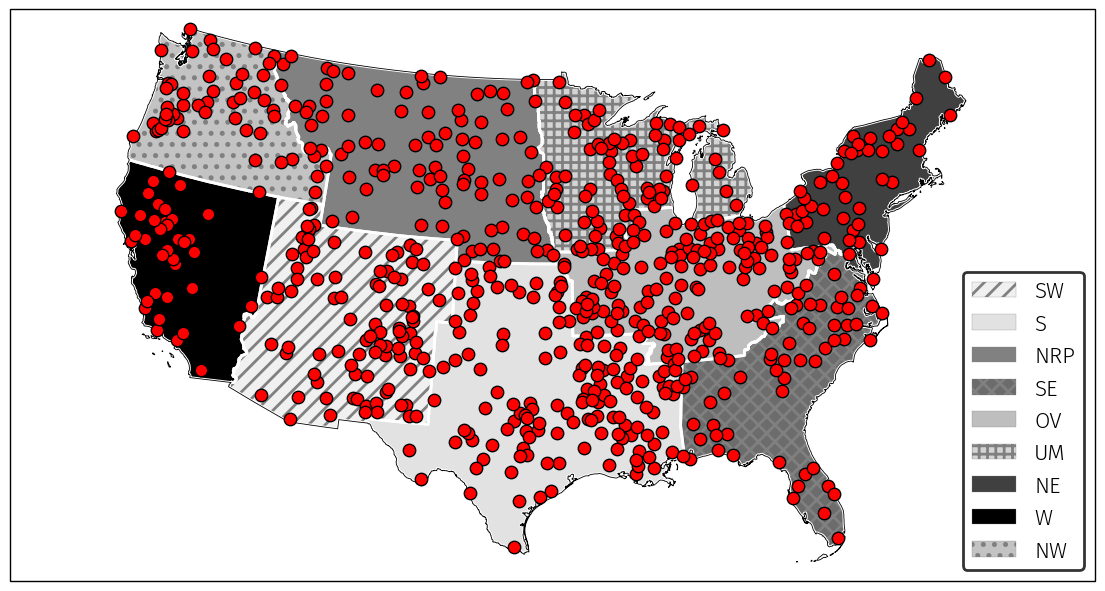

In [6]:
clim_reg = gpd.read_file('data/shp/clim_region_dissolve.shp')
usa = clim_reg.dissolve()

colors = ['#f0f0f0','#e2e2e2','#818181','#6c6c6c','#bebebe','#d4d4d4','#404040','#000000','#c3c3c3']
hatch = ['////', None, None, 'xxxx', None, '++++', None, None, '...']
regions = ['SW', 'S', 'NRP', 'SE', 'OV', 'UM', 'NE', 'W', 'NW']
proj_5070 = ccrs.AlbersEqualArea(central_longitude=-96, central_latitude=23, 
                                false_easting=0.0, false_northing=0.0, 
                                standard_parallels=(29.5, 45.5))

extent = [-125, -66.75, 24.5, 49.5]

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': proj_5070})

ax.add_geometries(usa.geometry, crs=ccrs.PlateCarree(), 
                color='none', edgecolor="k", linewidth=0.3, zorder=2)

for i, geom in enumerate(clim_reg.geometry):
    ax.add_geometries(geom, crs=ccrs.PlateCarree(), 
                  facecolor=colors[i], edgecolor="grey", linewidth=0.1, hatch=hatch[i], zorder=0)
    ax.add_geometries(geom, crs=ccrs.PlateCarree(), 
                  color='none', edgecolor="w", linewidth=1, zorder=1)
    


# Stations
for i, station in final_stations.iterrows():
    ax.scatter(
        x=station["Lon"],
        y=station["Lat"],
        transform=ccrs.PlateCarree(),
        edgecolors="k",
        color="red",
        s=20,
        zorder=10,
        linewidths=0.5,
    )
#ax.add_feature(cfeature.COASTLINE)
legend_elements = [Patch(facecolor=colors[i], edgecolor="grey", linewidth=0.1, hatch=hatch[i], label=regions[i]) for i in range(9)]
ax.legend(handles=legend_elements, loc='lower right', frameon=True, edgecolor='k')
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.savefig(OUTPUT_PATH / "figures/stations.pdf", dpi=300, format="pdf")
plt.show()